# Mutations

In [ ]:
import sys
# !{sys.executable} -m pip install ggplot
# !{sys.executable} -m pip install lightgbm

In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

import gc

In [3]:
def read_table(name):
    file_root = "https://storage.googleapis.com/genx_2018/"
    return pd.read_table(file_root + name, sep="\t")

def cat_encode(src, target, col):
    cols = pd.get_dummies(src[col], prefix=col, prefix_sep='_')
    return pd.concat([target, cols], axis=1)

def drop_nan_rows(table, col):
    res = table.dropna(axis=0, how='any', subset=[col])
    print('Dropping %d nan rows for %s, sz before: %d, sz after: %d' % (len(table)-len(res), col, len(table), len(res)))
    return res

def filter(table, col, value):
    res = table.loc[table[col] != value]
    print('Filtering %d rows with "%s" for %s, sz before: %d, sz after: %d' % (len(table) - len(res), value, col, len(table), len(res)))
    return res

phenotype_meta_table = read_table("Melanoma_Phenotype_Metadata.txt")
mutation_table = read_table("Melanoma_Mutation.txt")

### Prepare target

In [4]:
target_variable = 'Response To Therapy'
target_map = {
 "Complete Response": 0,
 "Clinical Progressive Disease": 1,
 "Radiographic Progressive Disease": 1,    
 "Stable Disease": 1,                      
 "Partial Response": 0   
}

pmt = pd.DataFrame()

pmt['Sample'] = phenotype_meta_table['SampleID']
pmt['Response To Therapy'] = phenotype_meta_table['Response To Therapy']
pmt = drop_nan_rows(pmt, 'Response To Therapy')
pmt['Response To Therapy'] = pmt['Response To Therapy'].apply(lambda x: target_map[x])

pmt[['Sample', target_variable]].groupby(by=target_variable, as_index=False).count()

Dropping 375 nan rows for Response To Therapy, sz before: 476, sz after: 101


,Response To Therapy,Sample
0,0,51
1,1,50


In [5]:
pmt.head(3)

,Sample,Response To Therapy
27,TCGA-D3-A1Q1-06,1
28,TCGA-D3-A1Q3-06,0
35,TCGA-D3-A1Q9-06,1


### Features

In [6]:
mutation_table.Effect.unique()

array(['Missense_Mutation', 'Silent', 'RNA', 'Translation_Start_Site',
       'Splice_Site', 'Nonsense_Mutation', 'Nonstop_Mutation',
       'Frame_Shift_Del', 'In_Frame_Ins', 'Frame_Shift_Ins', 'In_Frame_Del'], dtype=object)

In [7]:
# Filter Silent/RNA
mutation_table = filter(mutation_table, 'Effect', 'Silent')
mutation_table = filter(mutation_table, 'Effect', 'RNA')
mutation_table['Amino_Acid_Change'] = mutation_table['Amino_Acid_Change'].astype(str)

Filtering 136359 rows with "Silent" for Effect, sz before: 422553, sz after: 286194
Filtering 15642 rows with "RNA" for Effect, sz before: 286194, sz after: 270552


In [8]:
# Join tables
mutation_table = mutation_table.merge(pmt, how='inner', on='Sample')
mutation_table.head(3)

,Sample,Chr,Start,Stop,Ref,Alt,Gene,Effect,DNA_VAF,RNA_VAF,Amino_Acid_Change,Response To Therapy
0,TCGA-D3-A3ML-06,chr5,140182973,140182973,G,A,PCDHA3,Missense_Mutation,0.5,nan,p.D731N,1
1,TCGA-D3-A3ML-06,chr2,133541884,133541884,C,T,NCKAP5,Missense_Mutation,0.5,nan,p.E834K,1
2,TCGA-D3-A3ML-06,chr19,51217544,51217544,C,T,SHANK1,Missense_Mutation,0.2,nan,p.G179R,1


In [85]:
def make_xy(table, groups, count_filter = 0):
    mg = table \
            .groupby(groups) \
            .size() \
            .reset_index(name='Count') \
            .sort_values(['Count'], ascending=False)
    print('Most mutaed genes within {}:\n'.format(groups))
    print(mg.head(10))
        
    # Join groups: Gene_AADACL3|chr1|Translation_Start_Site
    tmp = pd.DataFrame()
    tmp['Sample'] = table['Sample']
    tmp['Gene'] = table[groups].apply(lambda x: '|'.join(x).strip(), axis=1)
    
    if count_filter > 0:
        mg['Gene'] = mg[groups].apply(lambda x: '|'.join(x).strip(), axis=1)
        mg = mg.loc[mg.Count > count_filter]
        unique_genes = mg['Gene']
        print('\nUsing count_filter > %d' % count_filter)
        print('Before: %d' % len(tmp))
        tmp = tmp.loc[tmp.Gene.isin(unique_genes)]
        print('After: %d' % len(tmp))
        
    print('\nUnique features: %d' % len(tmp['Gene'].unique()))
    
    # Extract features
    tmp = cat_encode(tmp, tmp, 'Gene')
    tmp = tmp.loc[:, tmp.columns != 'Gene']
    
    # Group by Sample
    tmp = tmp.groupby('Sample', as_index=False).sum()
 
    # Join targets
    tmp = tmp.merge(pmt, how='inner', on='Sample')
    
    y = tmp[target_variable]
    print('Target: ', y.shape)
    
    # tmp = tmp.set_index('Sample')
    tmp = tmp.loc[:, tmp.columns != 'Sample']
    tmp = tmp.loc[:, tmp.columns != target_variable]
    x = tmp
    print('Features: ', x.shape)
    
    return (x, y)

In [9]:
important_effects = [
    'Translation_Start_Site',
    'Frame_Shift_Ins',
    'Frame_Shift_Del',
    'Nonsense_Mutation',
    'Nonstop_Mutation']

# Important:
mutation_table_imp = mutation_table.loc[mutation_table.Effect.isin(important_effects)]
print(mutation_table_imp.shape)

# Less Important:
# In_Frame_Ins
# In_Frame_Del
# Missense_Mutation
# Splice_Site
mutation_table_less_imp = mutation_table.loc[~mutation_table.Effect.isin(important_effects)]
print(mutation_table_less_imp.shape)

(5494, 12)
(77466, 12)


In [56]:
# Important
x, y = make_xy(mutation_table_imp, ['Gene', 'Chr', 'Effect', 'Amino_Acid_Change'])

Most mutaed genes within ['Gene', 'Chr', 'Effect', 'Amino_Acid_Change']:

         Gene    Chr                  Effect Amino_Acid_Change  Count
2254    MCTP2  chr15  Translation_Start_Site               nan      4
1748   HS3ST4  chr16       Nonsense_Mutation           p.Q448*      4
2538     NID1   chr1       Nonsense_Mutation           p.W261*      4
3722    STON2  chr14       Nonsense_Mutation           p.W639*      4
3005      PPL  chr16       Nonsense_Mutation           p.W302*      4
3492  SLC11A1   chr2       Nonsense_Mutation            p.W98*      4
381      BCHE   chr3       Nonsense_Mutation           p.W550*      4
791   CNTNAP2   chr7       Nonsense_Mutation          p.R1088*      3
364   B3GALT1   chr2       Nonsense_Mutation           p.R273*      3
1246    ENPP5   chr6       Nonsense_Mutation           p.Q314*      3

Unique features: 4517
Target:  (98,)
Features:  (98, 4517)


In [ ]:
# Less Important
x, y = make_xy(mutation_table_less_imp, ['Gene', 'Chr', 'Effect', 'Amino_Acid_Change'])

In [86]:
# All features
x, y = make_xy(mutation_table, ['Gene', 'Chr', 'Effect', 'Amino_Acid_Change', 'Ref', 'Alt'], count_filter=2)

Most mutaed genes within ['Gene', 'Chr', 'Effect', 'Amino_Acid_Change', 'Ref', 'Alt']:

         Gene    Chr             Effect Amino_Acid_Change Ref Alt  Count
5776     BRAF   chr7  Missense_Mutation           p.V600E   A   T     40
37812    NRAS   chr1  Missense_Mutation            p.Q61R   T   C     15
37810    NRAS   chr1  Missense_Mutation            p.Q61K   G   T     12
5778     BRAF   chr7  Missense_Mutation           p.V600M   C   T     11
56930  THSD7B   chr2  Missense_Mutation          p.R1445Q   G   A      6
53369   SORL1  chr11        Splice_Site               nan   G   A      5
43760   PLCB4  chr20  Missense_Mutation           p.S670L   C   T      5
22455  GIMAP8   chr7  Missense_Mutation           p.E654K   G   A      5
48632   RQCD1   chr2  Missense_Mutation           p.P131L   C   T      5
3165     ANO4  chr12  Missense_Mutation           p.R803Q   G   A      5

Using count_filter > 2
Before: 82960
After: 2120

Unique features: 653
Target:  (93,)
Features:  (93, 653)


#### PCA

In [ ]:
pca = PCA(n_components=50)
pca.fit(x)

variance_pca = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

plt.ylabel('Variance')
plt.xlabel('Features')
plt.title('PCA Analysis')

plt.plot(variance_pca)

#### LDA

In [ ]:
lda = LDA(n_components=50)
lda.fit(x, y)

variance_lda = np.cumsum(np.round(lda.explained_variance_ratio_, decimals=3)*100)

plt.ylabel('Variance')
plt.xlabel('Features')
plt.title('LDA/PCA Analysis')
plt.plot(variance_lda, label='LDA')

#### LGBM

In [71]:
model = LGBMClassifier(boosting_type='goss')
print("mean acc:{}, var acc:{}".format(np.mean(cross_val_score(model, x, y, cv=10)),
                                       np.var(cross_val_score(model, x, y, cv=10))))
model.fit(x, y)
model.feature_importances_

mean acc:0.5602777777777778, var acc:0.013645138888888884


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

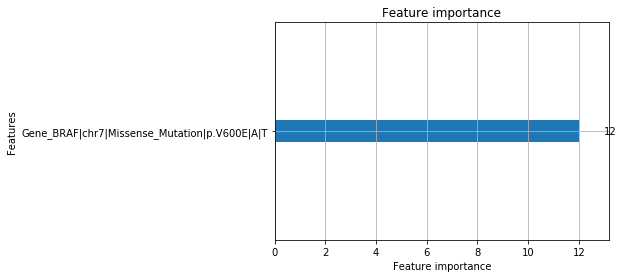

In [72]:
plot_importance(model)